In [97]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
from tqdm import tqdm

from graspy.embed import JointRDPG
from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.simulations import sbm

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import sbm_marg_corr_diff, ER_corr
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, power, non_diagonal, \
    estimate_block_assignment, block_permute

In [47]:
def rho_sbm_diff_block(rho, k, AL, BL, n=100):
    if sum(k) != n:
        raise ValueError('the total number of vertices in each community should equal n')
    
    if np.any(AL == 0) or np.any(AL == 1) \
            or np.any(BL == 0) or np.any(BL == 1):
        raise ValueError('block probabilities AL and BL cannot have 0 or 1')

    largest_rho = np.minimum(np.sqrt(AL*(1-BL)/((1-AL)*BL)), np.sqrt((1-AL)*BL/(AL*(1-BL))))
    if np.any(rho > largest_rho):
        raise ValueError('the largest valid rho for the specified AL and BL is {}. Please specify a rho that is smaller than the largest valid rho.'.format(
            np.amin(largest_rho)))

    AL = symmetrize(AL)
    BL = symmetrize(BL)
    A = sbm(k, AL)

    AL_new = np.zeros_like(A)
    BL_new = np.zeros_like(A)
    block_indices = np.insert(np.cumsum(np.array(k)), 0, 0)
    for i in range(AL.shape[0]):
        for j in range(AL.shape[1]):
            AL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = AL[i, j]
            BL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = BL[i, j]

    prob = BL_new + A*rho*np.sqrt((1-AL_new)*BL_new*(1-BL_new)/AL_new) - (1-A)*rho*np.sqrt(AL_new*BL_new*(1-BL_new)/(1-AL_new))
    B = np.random.binomial(1, prob)
    B = B.astype(np.float64)
    B = symmetrize(B)
    np.fill_diagonal(B, 0)
    return A, B

In [68]:
def off_diag_block_corr(A, B):
    A = A.flatten()
    B = B.flatten()
    x = np.vstack((A, B))
    return np.corrcoef(x)[0, 1]

In [77]:
def sbm_corr_diff_block(A, B, k):
    corr_sum = 0
    n = A.shape[0]
    block_indices = np.insert(np.cumsum(np.array(k)), 0, 0)
    for i in range(len(k)):
        for j in range(len(k)):
            block1 = A[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]]
            block2 = B[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]]
            if i == j:
                corr = ER_corr(block1, block2)
            else:
                corr = off_diag_block_corr(block1, block2)
            corr_sum += corr 
    return corr_sum / np.square(len(k))

In [88]:
rho = 0.3
n = 100
z = np.zeros(9)
for i, num_vertices in enumerate(np.linspace(10, 90, 9)):
    k = [int(num_vertices), 100-int(num_vertices)]
    AL = np.array([[0.7, 0.3], [0.3, 0.7]])
    BL = np.array([[0.5, 0.1], [0.1, 0.5]])
    monte = np.zeros(10)
    for j in range(10):
        try:
            A, B = rho_sbm_diff_block(rho, k, AL, BL, n)
        except ValueError as e:
            print(e)
            continue
        else:
            monte[j] = sbm_corr_diff_block(A, B, k)
    z[i] = rho - np.mean(monte)

In [89]:
z

array([ 0.01765558,  0.00240755,  0.00211513, -0.00329533, -0.00325872,
        0.00214507, -0.00306775,  0.01311435, -0.00745742])

In [81]:
k = [70, 30]
A, B = rho_sbm_diff_block(0.3, k, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3))

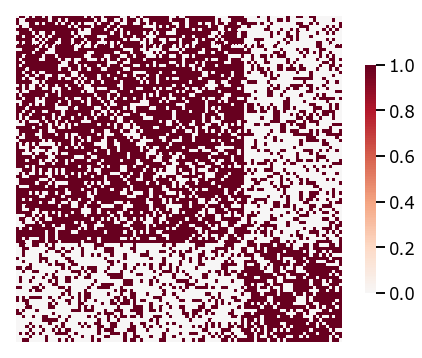

In [9]:
heatmap(A, figsize=(8, 6))

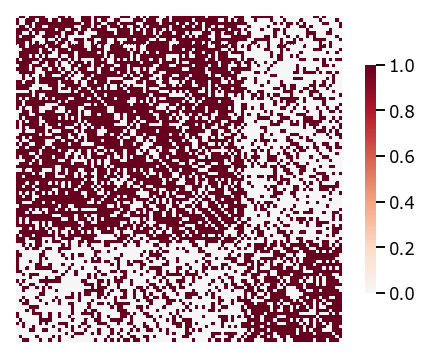

In [50]:
heatmap(B, figsize=(8, 6))

In [90]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_diff_block(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [101]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            k = [int(0.7*n), n-int(0.7*n)]
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.1, n=10
finish dcorr for rho=0.1, n=20
finish dcorr for rho=0.1, n=30
finish dcorr for rho=0.1, n=40
finish dcorr for rho=0.1, n=50
finish dcorr for rho=0.1, n=60
finish dcorr for rho=0.1, n=70
finish dcorr for rho=0.1, n=80
finish dcorr for rho=0.1, n=90
finish dcorr for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish mgc for rho=0.0, n=10
finish mgc for rho=0.0, n=20
finish mgc for rho=0.0, n=30
finish mgc for rho=0.0, n=40
finish mgc for rho=0.0, n=50
finish mgc for rho=0.0, n=60
finish mgc for rho=0.0, n=70
finish mgc for rho=0.0, n=80
finish mgc for rho=0.0, n=90
finish mgc for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish mgc for rho=0.1, n=10
finish mgc for rho=0.1, n=20
finish mgc for rho=0.1, n=30
finish mgc for rho=0.1, n=40
finish mgc for rho=0.1, n=50
finish mgc for rho=0.1, n=60
finish mgc for rho=0.1, n=70
finish mgc for rho=0.1, n=80
finish mgc for rho=0.1, n=90
finish mgc for rho=0.1, n=100
CPU times: user 22min 7s, sys: 1min 37s, total: 23min 44s
Wall time: 12min 9s


In [102]:
power_sbm

{'pearson': array([[0.072, 0.196, 0.052, 0.066, 0.078, 0.052, 0.054, 0.052, 0.078,
         0.044],
        [0.072, 0.024, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.004, 0.   , 0.   , 0.002, 0.042, 0.038, 0.052, 0.052, 0.056,
         0.054],
        [0.028, 0.042, 0.108, 0.638, 0.932, 0.978, 0.994, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.01 , 0.002, 0.002, 0.01 , 0.056, 0.048, 0.06 , 0.052, 0.054,
         0.038],
        [0.024, 0.028, 0.084, 0.656, 0.932, 0.962, 0.996, 1.   , 0.998,
         1.   ]])}

In [104]:
n_arr = np.linspace(10, 100, 10, dtype=int)
mpl.style.use('seaborn')

plt.figure(figsize=(8, 6))
colors = {
    'mgc': 'red',
    'dcorr': 'blue', 
    'pearson': 'orange'
}

<Figure size 576x432 with 0 Axes>

In [105]:
with open('../data/rho_sbm_diff_block_power.pkl', 'rb') as f:
    power_results = pickle.load(f)

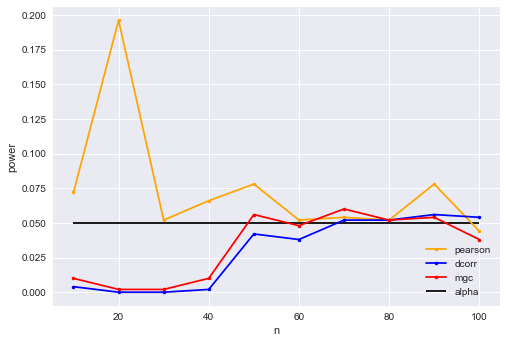

In [106]:
rho = 0
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[0, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=0.05, xmin=np.amin(n_arr), xmax=np.amax(n_arr), label='alpha')
plt.legend(loc=4)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_diff_block_power_null.png', bbox_inches='tight')

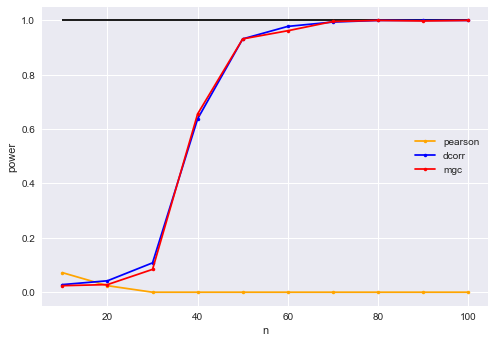

In [107]:
rho = 0.1
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[1, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=1, xmin=np.amin(n_arr), xmax=np.amax(n_arr))
plt.legend(loc=7)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_diff_block_power_alt.png'.format(rho), bbox_inches='tight')